❗❗❗❗Nota importante: El cuaderno de trabajo debe ser ejecutado usando la opción de aceleración de hardware mediante GPU. Dicha unidad es usada tanto en entrenamiento como en inferencia, como en el análisis de errores para las redes neuronales. 

In [ ]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Importar módulos de sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
# Especificar columnas
relevant_columns = ['Tienda','FORMATO','REGION','Categoria','Proveedor','DEPTO','SDEPTO','CLASE','SCLASE','Mes','DiaSem','Sem','Decil','Importado','MarcaPropia','EnOferta','Existencia','Desplazamiento','Y_Faltante']
numerical_columns = ['Existencia','Desplazamiento']
categorical_columns = ['Tienda','FORMATO','REGION','Categoria','Proveedor','DEPTO','SDEPTO','CLASE','SCLASE','Mes','DiaSem','Sem','Importado','MarcaPropia','Decil','EnOferta']
target_column = ['Y_Faltante']
data_columns = ['Decil','Existencia','Desplazamiento','Y_Faltante']

In [ ]:
# Abrir el archivo
file = 'Datos_faltante_sin_historico.csv'
data = pd.read_csv(file, header=0, usecols=data_columns)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 3889  columns: 4


In [ ]:
# Buscamos datos nulos dentro de las características numéricas de nuestras variables
total = data.isnull().sum()
percent = (
        data.isnull().sum() \
        / data.isnull().count()*100
        )
pd.concat([total,percent], axis=1, \
        keys=['Total','Percent']).transpose()

,Decil,Existencia,Desplazamiento,Y_Faltante
Total,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0


In [ ]:
data

,Decil,Existencia,Desplazamiento,Y_Faltante
0,1,696,10820,0
1,1,1113,4783,0
2,1,283,979,0
3,1,74,199,0
4,4,12,42,0
...,...,...,...,...
3884,4,0,118,1
3885,4,0,118,1
3886,4,0,31,1
3887,4,0,31,1


yes %: 49.601439958858315- no %: 50.398560041141685


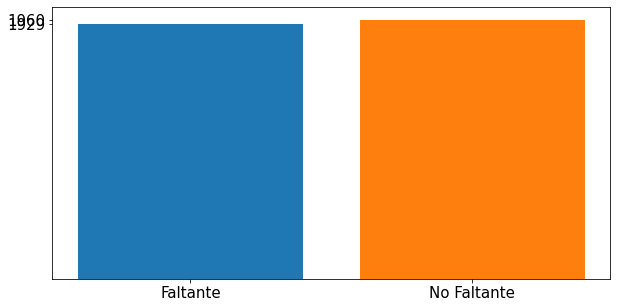

In [ ]:
# Revisamos la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

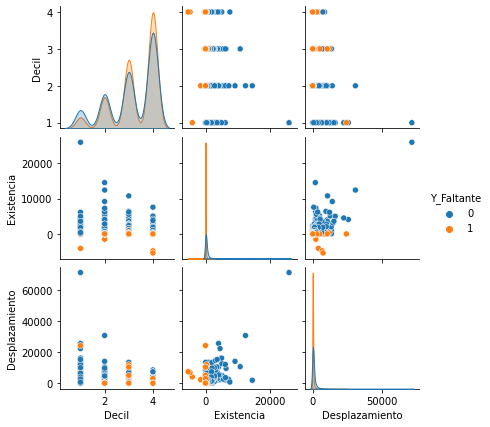

In [ ]:
# Gráfico de relaciones por pares
sns.pairplot(data, hue='Y_Faltante', height=2.);

In [ ]:
data

,Decil,Existencia,Desplazamiento,Y_Faltante
0,1,696,10820,0
1,1,1113,4783,0
2,1,283,979,0
3,1,74,199,0
4,4,12,42,0
...,...,...,...,...
3884,4,0,118,1
3885,4,0,118,1
3886,4,0,31,1
3887,4,0,31,1


In [ ]:
data_shuffled = data.sample(frac=1).reset_index(drop=True)
data_shuffled

,Decil,Existencia,Desplazamiento,Y_Faltante
0,4,0,92,1
1,3,330,757,1
2,4,0,168,1
3,2,0,0,1
4,3,110,147,1
...,...,...,...,...
3884,3,1044,367,0
3885,2,0,310,1
3886,3,0,27,1
3887,4,3778,3210,0


In [ ]:
data.shape[0],data.shape[1]

(3889, 4)

In [ ]:
data['Y_Faltante'].value_counts()

0    1960
1    1929
Name: Y_Faltante, dtype: int64

## Algoritmo para generar desbalance de clase.

Vamos a producir un imbalance de clase que mimetice la proporción de  -datos encontrados para muestras de datos en pruebas de campo.

Nota: Elija el porcentaje buscado de elementos *no faltantes* en el dataset desbalanceado.

In [ ]:
# Extrae los elementos que no son faltantes de anaquel del dataset
no_faltante = data[data['Y_Faltante']==0]
no_faltante

,Decil,Existencia,Desplazamiento,Y_Faltante
0,1,696,10820,0
1,1,1113,4783,0
2,1,283,979,0
3,1,74,199,0
4,4,12,42,0
...,...,...,...,...
3871,4,79,256,0
3872,4,3,34,0
3877,4,2,18,0
3880,4,364,2729,0


In [ ]:
import math
import random 
# El imput 'frame' se refiere al dataframe al cual se le extraerá un subconjunto de elementos faltantes de anaquel en una proporción dada.
# Porcentaje_faltante es el porcentaje deseado de elementos que son NO faltante (es decir, el procentaje mayor). 

# Guardamos el número de elementos no faltantes en una variable
num_no_faltante = no_faltante.shape[0]

def faltante(frame,procentaje_no_faltante):
  faltantes = frame[frame['Y_Faltante']==1] # Extraemos los elementos que son faltante de anaquel
  a = (num_no_faltante*100)/procentaje_no_faltante - num_no_faltante 
  num_deseado_faltantes = int(math.floor(a))
  b = random.randint(0,faltantes.shape[0]-2)
  df = faltantes[b:b+1] # Tomamos un elemento faltante al azar
  while df['Y_Faltante'].shape[0] < num_deseado_faltantes:
    c = random.randint(0,faltantes.shape[0]-3)
    df2 = faltantes.iloc[c:c+1]
    df3 = pd.concat([df,df2],ignore_index=True)
    df = df3
  return df

In [ ]:
# Este será nuestro conjunto de datos con una proporción 'No faltante-93%' vs 'Faltante-7%'
unbalanced_data = pd.concat([no_faltante,faltante(data,93)],axis=0)
unbalanced_data = unbalanced_data.sample(frac=1).reset_index(drop=True)
unbalanced_data

,Decil,Existencia,Desplazamiento,Y_Faltante
0,4,20,48,0
1,4,596,1302,0
2,2,2610,4421,0
3,3,83,124,0
4,4,517,307,0
...,...,...,...,...
2102,1,903,2314,0
2103,4,0,1,1
2104,4,209,373,0
2105,3,0,1,1


In [ ]:
# Algunas funciones auxiliares 
import random 
import math

# Esta función va a crear un dataframe con porcentaje dado de faltante original
def crea_faltante(frame,porcentaje):
  
  num_deseado_faltantes = int(math.floor((frame.shape[0]*porcentaje)/100))
  a = random.randint(0,frame.shape[0]-2) # Tomamos el índice de una fila al azar
  df = frame[a:a+1] # Elegimos un renglón del dataset al azar para comenzar a construir un nuevo dataframe
  while df['Y_Faltante'].value_counts()[1] < num_deseado_faltantes:
    r = random.randint(0,frame.shape[0]-3)
    if frame['Y_Faltante'].iloc[r] == 1:
      df2 = frame.iloc[a:a+1]
      df3 = pd.concat([df,df2],ignore_index=True)
      df = df3
  return df


# Esta función va a crear un dataframe con porcentaje dado de faltante original
def crea_no_faltante(frame,porcentaje):
  num_deseado_faltantes = int(math.floor((frame.shape[0]*porcentaje)/100))
  a = random.randint(0,frame.shape[0]-2) # Tomamos el índice de una fila al azar
  df = frame[a:a+1] # Elegimos un renglón del dataset al azar para comenzar a construir un nuevo dataframe
  while df['Y_Faltante'].value_counts()[1] < num_deseado_faltantes:
    r = random.randint(0,frame.shape[0]-3)
    if frame['Y_Faltante'].iloc[r] == 0:
      df2 = frame.iloc[a:a+1]
      df3 = pd.concat([df,df2],ignore_index=True)
      df = df3
  return df

In [ ]:
# Aislamos las variables numéricas y realizamos sobre ellas un min-max scaling
decil = unbalanced_data['Decil']

numerical = unbalanced_data.drop(columns=["Decil","Y_Faltante"])
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min()) 

faltante = unbalanced_data["Y_Faltante"]

In [ ]:
# Creamos y guardamos nuestro conjunto de datos final
unbalanced_data_final = pd.concat([decil,numerical_scaled,faltante],axis=1)
unbalanced_data_final

,Decil,Existencia,Desplazamiento,Y_Faltante
0,4,0.004689,0.000671,0
1,4,0.026828,0.018211,0
2,2,0.104236,0.061835,0
3,3,0.007110,0.001734,0
4,4,0.023791,0.004294,0
...,...,...,...,...
2102,1,0.038627,0.032365,0
2103,4,0.003920,0.000014,1
2104,4,0.011953,0.005217,0
2105,3,0.003920,0.000014,1


In [ ]:
X = unbalanced_data.drop('Y_Faltante', axis=1)
y = unbalanced_data['Y_Faltante']
X

,Decil,Existencia,Desplazamiento
0,4,20,48
1,4,596,1302
2,2,2610,4421
3,3,83,124
4,4,517,307
...,...,...,...
2102,1,903,2314
2103,4,0,1
2104,4,209,373
2105,3,0,1


# Primer Prueba 
* Agrupación K-Means
* Variables de interés escaladas (excepto Decil y K-Medoids)
* Escalamiento MinMax
* Sin eliminar outliers

In [ ]:
# Generamos una copia de nuestros conjuntos de datos para esta primera ronda de experimentos
X1 = X.copy()
y1 = y.copy()
data1 = pd.concat([X1,y1],axis=1)

In [ ]:
# Visualizamos nuestros datos
data1

,Decil,Existencia,Desplazamiento,Y_Faltante
0,4,20,48,0
1,4,596,1302,0
2,2,2610,4421,0
3,3,83,124,0
4,4,517,307,0
...,...,...,...,...
2102,1,903,2314,0
2103,4,0,1,1
2104,4,209,373,0
2105,3,0,1,1


In [ ]:
# Algunas estadísticas de nuestros datos
data1.describe()

,Decil,Existencia,Desplazamiento,Y_Faltante
count,2107.000000,2107.000000,2107.000000,2107.000000
mean,3.134789,391.337921,910.340769,0.069767
std,0.980271,1076.623578,2455.825434,0.254815
min,1.000000,-102.000000,0.000000,0.000000
25%,2.000000,25.000000,83.000000,0.000000
50%,3.000000,85.000000,279.000000,0.000000
75%,4.000000,307.000000,801.000000,0.000000
max,4.000000,25916.000000,71497.000000,1.000000


yes %: 6.976744186046512- no %: 93.02325581395348


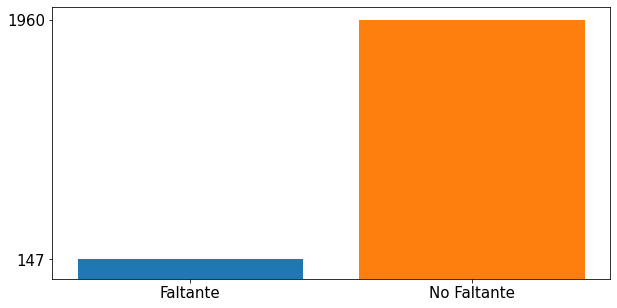

In [ ]:
# Revisamos la proporción de datos
target = data1['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

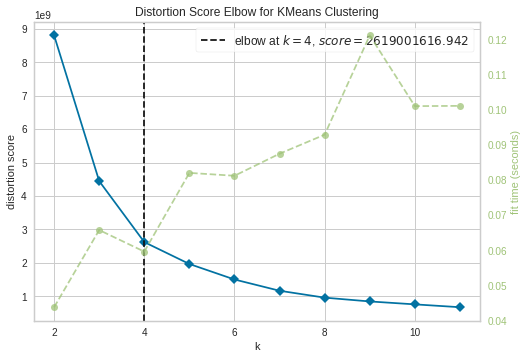

In [ ]:
# Método del codo
#!pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans()
visualizer = KElbowVisualizer(km, k=(2,12), metric='distortion')
visualizer.fit(X1)
visualizer.show();

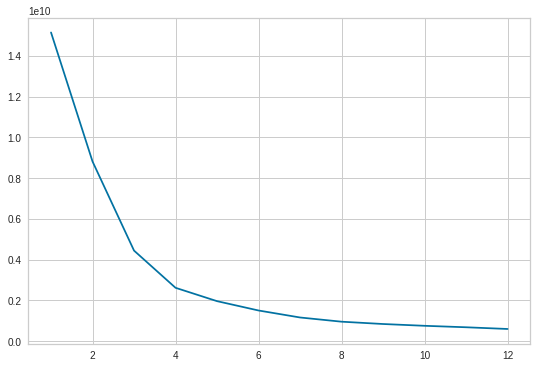

In [ ]:
# Método del codo
distortions = []
for k in range(1,13):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X1)
    distortions.append(kmeanModel.inertia_)

fig, ax = plt.subplots(figsize = (9,6))
sns.lineplot(x=range(1,13), y=distortions, ax=ax);

In [ ]:
# Particionar el dataset en 4 clusters
km = KMeans(n_clusters=4, max_iter=1000, random_state=0).fit(X1)
X1['K_Means'] = km.labels_

In [ ]:
# Transformar en tipo de datos categórico
X1['Decil'] = pd.Categorical(X1.Decil)
X1['K_Means'] = pd.Categorical(X1.K_Means)

In [ ]:
# Observamos el conjunto de características final
X1

,Decil,Existencia,Desplazamiento,K_Means
0,4,20,48,0
1,4,596,1302,0
2,2,2610,4421,1
3,3,83,124,0
4,4,517,307,0
...,...,...,...,...
2102,1,903,2314,1
2103,4,0,1,0
2104,4,209,373,0
2105,3,0,1,0


In [ ]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
print('Entrenamiento:', X1_train.shape[0], ' Prueba:', X1_test.shape[0])

Entrenamiento: 1685  Prueba: 422


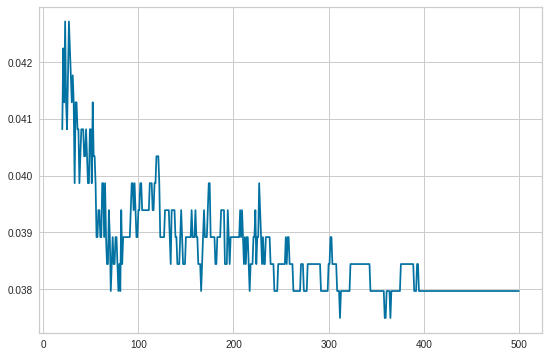

In [ ]:
# Calcular el Error OOB
n_estimators = 500
error_rate = []
rfc = RandomForestClassifier(warm_start=True, oob_score=True, random_state=0)
for i in range(20, n_estimators + 1):
    rfc.set_params(n_estimators=i)
    rfc.fit(X1, y1)
    oob_error = 1 - rfc.oob_score_
    error_rate.append(oob_error)

fig, ax = plt.subplots(figsize = (9,6))
sns.lineplot(x=range(20, n_estimators + 1), y=error_rate, ax=ax);

# Aplicación de algoritmos

In [ ]:
# Importar modelos
# !pip install xgboost
# !pip install lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
# Lista de modelos
seed=0

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LOGIT', LogisticRegression(random_state=seed)))
models.append(('SVC', SVC(random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('ADABOOST', AdaBoostClassifier(random_state=seed)))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))
#models.append(('XGB', XGBClassifier(eval_metric='mlogloss', seed=seed)))
models.append(('LGBM', LGBMClassifier(random_state=seed)))
models.append(('DeciTree', DecisionTreeClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))

In [ ]:
for name, model in models:
        model.fit(X1_train, y1_train)
        y_predict =  model.predict(X1_test)
        print(f'\nPrecisión entrenamiento {name}:', model.score(X1_train, y1_train).round(4))
        print(f'Precisión prueba {name}:', model.score(X1_test, y1_test).round(4))
        del y_predict


Precisión entrenamiento KNN: 0.9614
Precisión prueba KNN: 0.9336

Precisión entrenamiento NB: 0.4196
Precisión prueba NB: 0.4336

Precisión entrenamiento LOGIT: 0.9335
Precisión prueba LOGIT: 0.9194

Precisión entrenamiento SVC: 0.9329
Precisión prueba SVC: 0.9194

Precisión entrenamiento RF: 1.0
Precisión prueba RF: 0.9597

Precisión entrenamiento ADABOOST: 0.9626
Precisión prueba ADABOOST: 0.9526

Precisión entrenamiento GBC: 0.9769
Precisión prueba GBC: 0.9502

Precisión entrenamiento LGBM: 0.9958
Precisión prueba LGBM: 0.9526

Precisión entrenamiento DeciTree: 1.0
Precisión prueba DeciTree: 0.9408

Precisión entrenamiento AdaBoost: 0.9626
Precisión prueba AdaBoost: 0.9526


# Análisis de Errores

## Vanilla Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X1_train, y1_train)
rfc.predict(X1_test)
acc_train = rfc.score(X1_train,y1_train)
acc_test = rfc.score(X1_test,y1_test)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 1.0, Presición validación: 0.9597


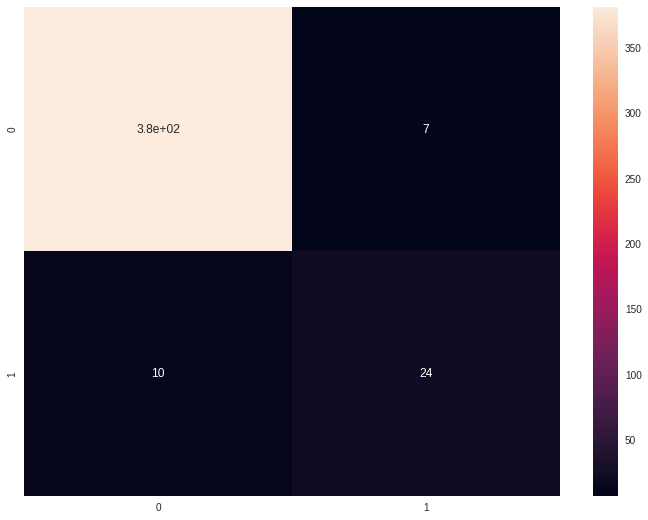

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = rfc.predict(X1_test)
mat = confusion_matrix(y1_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y1_test, y_pred).ravel()
tn,fp,fn,tp

(381, 7, 10, 24)

In [ ]:
accuracy = accuracy_score(y1_test,y_pred)
recall = recall_score(y1_test,y_pred)
precision = precision_score(y1_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y1_test,y_pred)
f1 = f1_score(y1_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9597156398104265
True Positive Rate 0.7058823529411765
Precision 0.7741935483870968
Balanced accuracy 0.8439205579138872
f1 score 0.7384615384615385


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<AxesSubplot:>

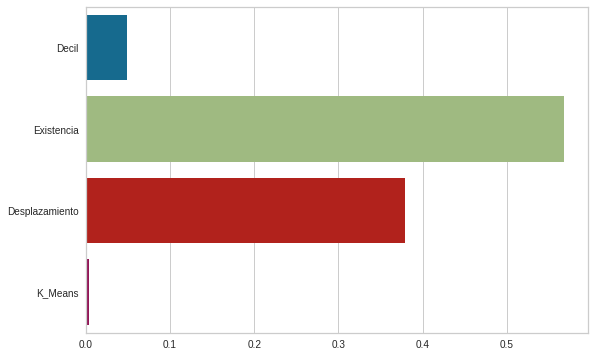

In [ ]:
!pip install matplotlib==3.4
# Graficamos la importancia de las variables
# Graficar la importancia de las variables
fi1 = pd.Series(rfc.feature_importances_, index=X1.columns)

fig, ax = plt.subplots(figsize = (9,6))
sns.barplot(x=fi1.values, y=fi1.index, ax=ax)
#ax.bar_label(ax.containers[0]);

In [ ]:
# Imprimimos un reporte de clasificación
from sklearn.metrics import classification_report
target_names = ['Faltante', 'No Faltante']
print(classification_report(y1_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Faltante       0.97      0.98      0.98       388
 No Faltante       0.77      0.71      0.74        34

    accuracy                           0.96       422
   macro avg       0.87      0.84      0.86       422
weighted avg       0.96      0.96      0.96       422



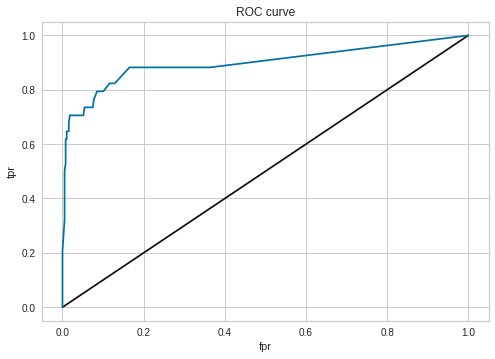

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = rfc.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
# Probamos el modelo usando validación cruzada
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, X1_test,y1_test,scoring='accuracy',verbose=1, cv=3))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.95744681 0.93617021 0.92857143]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


# Vanilla LGBMClassifier


In [ ]:
#from sklearn.ensemble import GradientBoostClassifier
lgbm = LGBMClassifier(random_state=0)
lgbm.fit(X1_train, y1_train)
lgbm.predict(X1_test)
acc_train = lgbm.score(X1_train,y1_train)
acc_test = lgbm.score(X1_test,y1_test)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9958, Presición validación: 0.9526


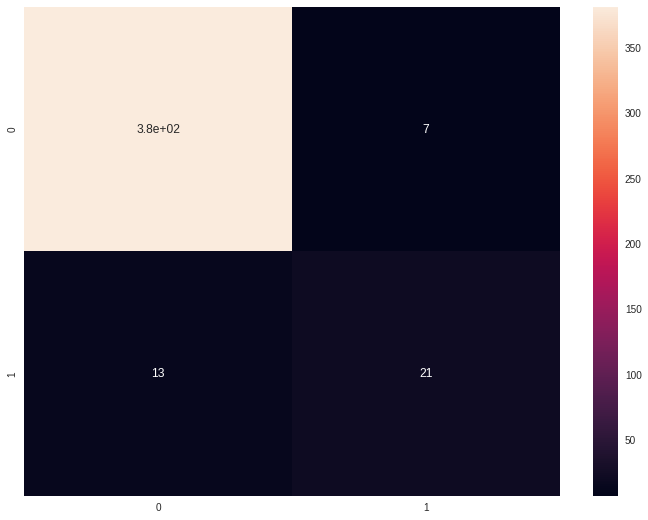

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = lgbm.predict(X1_test)
mat = confusion_matrix(y1_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y1_test, y_pred).ravel()
tn,fp,fn,tp

(381, 7, 13, 21)

In [ ]:
accuracy = accuracy_score(y1_test,y_pred)
recall = recall_score(y1_test,y_pred)
precision = precision_score(y1_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y1_test,y_pred)
f1 = f1_score(y1_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.95260663507109
True Positive Rate 0.6176470588235294
Precision 0.75
Balanced accuracy 0.7998029108550637
f1 score 0.6774193548387097


In [ ]:
# Imprimimos un reporte de clasificación
from sklearn.metrics import classification_report
target_names = ['Faltante', 'No Faltante']
print(classification_report(y1_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Faltante       0.97      0.98      0.97       388
 No Faltante       0.75      0.62      0.68        34

    accuracy                           0.95       422
   macro avg       0.86      0.80      0.83       422
weighted avg       0.95      0.95      0.95       422



<AxesSubplot:>

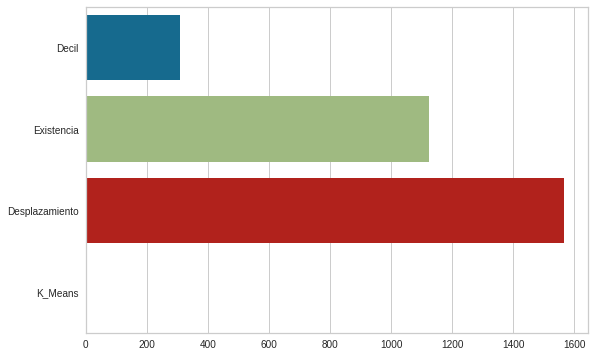

In [ ]:
# Graficar la importancia de las variables
fi2 = pd.Series(lgbm.feature_importances_, index=X1.columns)
fig, ax = plt.subplots(figsize = (9,6))
sns.barplot(x=fi2.values, y=fi2.index, ax=ax)
#ax.bar_label(ax.containers[0]);

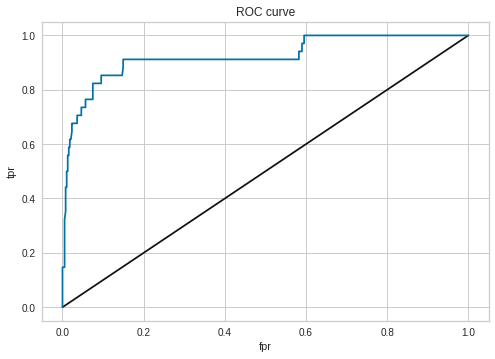

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = lgbm.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
# Probamos el modelo usando validación cruzada
from sklearn.model_selection import cross_val_score
print(cross_val_score(lgbm, X1_test,y1_test,scoring='accuracy',verbose=1, cv=3))

[0.93617021 0.92907801 0.93571429]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


# Local Cascade Ensemble

* [Reference](https://arxiv.org/abs/2005.03645v2)

In [ ]:
!pip install lcensemble

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Entrenamos un LCE con los parametros por defecto
from lce import LCEClassifier
clf = LCEClassifier(n_jobs=-1, random_state=123)
clf.fit(X1_train, y1_train)
clf.predict(X1_test)
acc_train = clf.score(X1_train,y1_train)
acc_test = clf.score(X1_test,y1_test)
print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9436, Presición validación: 0.9313


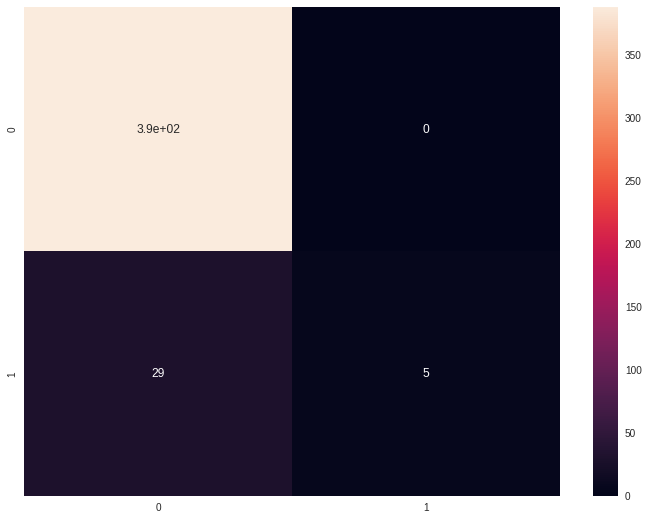

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = clf.predict(X1_test)
mat = confusion_matrix(y1_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y1_test, y_pred).ravel()
tn,fp,fn,tp

(388, 0, 29, 5)

In [ ]:
accuracy = accuracy_score(y1_test,y_pred)
recall = recall_score(y1_test,y_pred)
precision = precision_score(y1_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y1_test,y_pred)
f1 = f1_score(y1_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9312796208530806
True Positive Rate 0.14705882352941177
Precision 1.0
Balanced accuracy 0.5735294117647058
f1 score 0.25641025641025644


In [ ]:
# Imprimimos un reporte de clasificación
from sklearn.metrics import classification_report
target_names = ['Faltante', 'No Faltante']
print(classification_report(y1_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Faltante       0.93      1.00      0.96       388
 No Faltante       1.00      0.15      0.26        34

    accuracy                           0.93       422
   macro avg       0.97      0.57      0.61       422
weighted avg       0.94      0.93      0.91       422



In [ ]:
# Graficar la importancia de las variables
#fi3 = pd.Series(lce.feature_importances_, index=X1.columns)
#fig, ax = plt.subplots(figsize = (9,6))
#sns.barplot(x=fi3.values, y=fi3.index, ax=ax)
#ax.bar_label(ax.containers[0]);

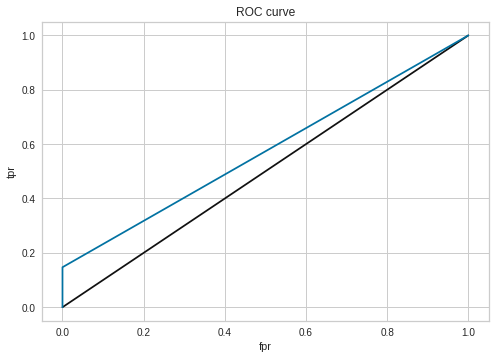

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = clf.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
# Probamos el modelo usando validación cruzada
from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, X1_test,y1_test,scoring='accuracy',verbose=1, cv=3))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.93617021 0.94326241 0.92142857]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 41.5min finished


# Redes Neuronales

In [ ]:
# Importamos librerías básicas para hacer uso de redes neuronales
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
# Generamos un catálogo de redes neuronales a ser usadas como algoritmo faltante de anaquel
class Red_Ago1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 500)
        self.hidden_2 = nn.Linear(500, 500)
        self.hidden_3 = nn.Linear(500, 100)
        self.hidden_4 = nn.Linear(100, 100)
        self.hidden_5 = nn.Linear(100, 100)
        self.hidden_6 = nn.Linear(100, 10)
        self.hidden_7 = nn.Linear(10, 10)
        self.hidden_8 = nn.Linear(10, 10)
        self.hidden_9 = nn.Linear(10, 10)
        self.hidden_10 = nn.Linear(10, 10)
        self.hidden_11 = nn.Linear(10, 10)
        self.hidden_12 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.batchnorm4 = nn.BatchNorm1d(100)
        self.batchnorm5 = nn.BatchNorm1d(100)
        self.batchnorm6 = nn.BatchNorm1d(10)
        self.batchnorm7 = nn.BatchNorm1d(10)
        self.batchnorm8 = nn.BatchNorm1d(10)
        self.batchnorm9 = nn.BatchNorm1d(10)
        self.batchnorm10 = nn.BatchNorm1d(10)
        self.batchnorm11 = nn.BatchNorm1d(10)

    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = self.batchnorm1(z)
        z = F.relu(self.hidden_2(z))
        z = self.batchnorm2(z)
        z = F.relu(self.hidden_3(z))
        z = self.batchnorm3(z)
        z = F.relu(self.hidden_4(z))
        z = self.batchnorm4(z)
        z = F.relu(self.hidden_5(z))
        z = self.batchnorm5(z)
        z = F.relu(self.hidden_6(z))
        z = self.batchnorm6(z)
        z = F.relu(self.hidden_7(z))
        z = self.batchnorm7(z)
        z = F.relu(self.hidden_8(z))
        z = self.batchnorm8(z)
        z= F.relu(self.hidden_9(z))
        z = self.batchnorm9(z)
        z = F.relu(self.hidden_10(z))
        z = self.batchnorm10(z)
        z = F.relu(self.hidden_11(z))
        z = self.batchnorm11(z)
        z = F.relu(self.hidden_12(z))

        out = F.log_softmax(self.output(z), dim=1)

        return out

class Red_Ago2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 500)
        self.hidden_2 = nn.Linear(500, 500)
        self.hidden_3 = nn.Linear(500, 100)
        self.hidden_4 = nn.Linear(100, 100)
        self.hidden_5 = nn.Linear(100, 100)
        self.hidden_6 = nn.Linear(100, 10)
        self.hidden_7 = nn.Linear(10, 10)
        self.hidden_8 = nn.Linear(10, 10)
        self.hidden_9 = nn.Linear(10, 10)
        self.hidden_10 = nn.Linear(10, 10)
        self.hidden_11 = nn.Linear(10, 10)
        self.hidden_12 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.batchnorm4 = nn.BatchNorm1d(100)
        self.batchnorm5 = nn.BatchNorm1d(100)
        self.batchnorm6 = nn.BatchNorm1d(10)
        self.batchnorm7 = nn.BatchNorm1d(10)
        self.batchnorm8 = nn.BatchNorm1d(10)
        self.batchnorm9 = nn.BatchNorm1d(10)
        self.batchnorm10 = nn.BatchNorm1d(10)
        self.batchnorm11 = nn.BatchNorm1d(10)

    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = self.batchnorm1(z)
        z = F.relu(self.hidden_2(z))
        z = self.batchnorm2(z)
        z = F.relu(self.hidden_3(z))
        z = self.batchnorm3(z)
        z = F.relu(self.hidden_4(z))
        z = self.batchnorm4(z)
        z = F.relu(self.hidden_5(z))
        z = self.batchnorm5(z)
        z = F.relu(self.hidden_6(z))
        z = self.batchnorm6(z)
        z = F.relu(self.hidden_7(z))
        z = self.batchnorm7(z)
        z = F.relu(self.hidden_8(z))
        z = self.batchnorm8(z)
        z= F.relu(self.hidden_9(z))
        z = self.batchnorm9(z)
        z = F.relu(self.hidden_10(z))
        z = self.batchnorm10(z)
        z = F.relu(self.hidden_11(z))
        z = self.batchnorm11(z)
        z = F.relu(self.hidden_12(z))

        out = F.log_softmax(self.output(z), dim=1)

        return out

class Red_Ago3(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 500)
        self.hidden_2 = nn.Linear(500, 500)
        self.hidden_3 = nn.Linear(500, 100)
        self.hidden_4 = nn.Linear(100, 100)
        self.hidden_5 = nn.Linear(100, 100)
        self.hidden_6 = nn.Linear(100, 10)
        self.hidden_7 = nn.Linear(10, 10)
        self.hidden_8 = nn.Linear(10, 10)
        self.hidden_9 = nn.Linear(10, 10)
        self.hidden_10 = nn.Linear(10, 10)
        self.hidden_11 = nn.Linear(10, 10)
        self.hidden_12 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.batchnorm4 = nn.BatchNorm1d(100)
        self.batchnorm5 = nn.BatchNorm1d(100)
        self.batchnorm6 = nn.BatchNorm1d(10)
        self.batchnorm7 = nn.BatchNorm1d(10)
        self.batchnorm8 = nn.BatchNorm1d(10)
        self.batchnorm9 = nn.BatchNorm1d(10)
        self.batchnorm10 = nn.BatchNorm1d(10)
        self.batchnorm11 = nn.BatchNorm1d(10)

    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = self.batchnorm1(z)
        z = F.relu(self.hidden_2(z))
        z = self.batchnorm2(z)
        z = F.relu(self.hidden_3(z))
        z = self.batchnorm3(z)
        z = F.relu(self.hidden_4(z))
        z = self.batchnorm4(z)
        z = F.relu(self.hidden_5(z))
        z = self.batchnorm5(z)
        z = F.relu(self.hidden_6(z))
        z = self.batchnorm6(z)
        z = F.relu(self.hidden_7(z))
        z = self.batchnorm7(z)
        z = F.relu(self.hidden_8(z))
        z = self.batchnorm8(z)
        z= F.relu(self.hidden_9(z))
        z = self.batchnorm9(z)
        z = F.relu(self.hidden_10(z))
        z = self.batchnorm10(z)
        z = F.relu(self.hidden_11(z))
        z = self.batchnorm11(z)
        z = F.relu(self.hidden_12(z))

        out = F.log_softmax(self.output(z), dim=1)

        return out

# Experimentos con redes neuronales (usamos agrupación k-means)

In [ ]:
# Construímos una copia con los datos obtenidos luego de aplicar una agrupación k-means.
features = X1.copy()
target = y1.copy()

In [ ]:
# Segmentamos nuestros datos en entrenamiento-prueba y validación.
X_new, X_test, y_new, y_test = train_test_split(features,target, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

In [ ]:
# Pasamos nuestros datos de prueba a tensores (los elementos de entrenaminto serán convertidos durante el entrenamiento)
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

In [ ]:
# Experimento con agrupación K-means
model1 = Red_Ago1(X_train.shape[1]).to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model1.parameters(), lr=0.0001)

epochs = 2000
batch_size = 128


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model1(X_batch.to('cuda'))
        loss = criterion(log_ps, y_batch.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model1(X_test_torch.to('cuda'))
        dev_loss = criterion(log_dev, y_test_torch.to('cuda'))

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%200 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
# Alojamos los tensores de validación en la gpu de Google
log_dev  = model1(X_dev_torch.to('cuda'))
dev_loss = criterion(log_dev, y_dev_torch.to('cuda'))
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
model2 = Red_Ago2(X_train.shape[1]).to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model2.parameters(), lr=0.0001)

epochs = 3000
batch_size = 128


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model2(X_batch.to('cuda'))
        loss = criterion(log_ps, y_batch.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model2(X_test_torch.to('cuda'))
        dev_loss = criterion(log_dev, y_test_torch.to('cuda'))

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%200 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
# Alojamos los tensores de validación en la gpu de Google
log_dev  = model2(X_dev_torch.to('cuda'))
dev_loss = criterion(log_dev, y_dev_torch.to('cuda'))
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
#Entrenamos la red Red_Ago3 consiguiendo 94% de media como val_Acc 

model3 = Red_Ago3(X_train.shape[1]).to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model3.parameters(), lr=0.0001)

epochs = 2000
batch_size = 128


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model3(X_batch.to('cuda'))
        loss = criterion(log_ps, y_batch.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model3(X_test_torch.to('cuda'))
        dev_loss = criterion(log_dev, y_test_torch.to('cuda'))

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%200 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
# Alojamos los tensores de validación en la gpu de Google
log_dev  = model3(X_dev_torch.to('cuda'))
dev_loss = criterion(log_dev, y_dev_torch.to('cuda'))
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

# Experimentos con redes neuronales sin agrupación K-means

In [ ]:
X = X.drop(columns=['Decil'])
# Recuerde la definición de 'y' dada en la primer sección del cuaderno.
# Segmentamos nuestros datos en entrenamiento-prueba y validación.
X_new, X_test, y_new, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

In [ ]:
# Pasamos nuestros datos de prueba a tensores (los elementos de entrenaminto serán convertidos durante el entrenamiento)
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

In [ ]:
model4 = Red_Ago1(X_train.shape[1]).to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model4.parameters(), lr=0.0001)

epochs = 3000
batch_size = 128


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model4(X_batch.to('cuda'))
        loss = criterion(log_ps, y_batch.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model4(X_test_torch.to('cuda'))
        dev_loss = criterion(log_dev, y_test_torch.to('cuda'))

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%200 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
# Alojamos los tensores de validación en la gpu de Google
log_dev  = model4(X_dev_torch.to('cuda'))
dev_loss = criterion(log_dev, y_dev_torch.to('cuda'))
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
model5 = Red_Ago3(X_train.shape[1]).to('cuda')
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model5.parameters(), lr=0.0001)

epochs = 4000
batch_size = 128


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model5(X_batch.to('cuda'))
        loss = criterion(log_ps, y_batch.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model5(X_test_torch.to('cuda'))
        dev_loss = criterion(log_dev, y_test_torch.to('cuda'))

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%200 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc))

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
# Alojamos los tensores de validación en la gpu de Google
log_dev  = model5(X_dev_torch.to('cuda'))
dev_loss = criterion(log_dev, y_dev_torch.to('cuda'))
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_dev_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
import math
import random

def extrae(frame,cantidad):
  
